<a href="https://colab.research.google.com/github/blcrow/ua101/blob/main/Demand_Response.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selecting Optimal Customers for Demand Response Programs

## Introduction

The smart grid uses new technologies such as intelligent controllers, advanced software for data management, and two-way communications between power utilities and consumers to improve the efficiency, reliability and safety of the system [1]. This technology is providing new opportunities to advance the energy industry. Demand response (DR) programs are an example. 

The California PUC defines DR as "reductions, increases, or shifts in electricity consumption by customers in response to their economic signals or reliability signals" [[2]](https://www.cpuc.ca.gov/industries-and-topics/electrical-energy/electric-costs/demand-response-dr). Signals are typically either economic in nature (financial incentives, electricity prices) or related to electricity reliability (alerts that the grid is under stress). Recent DR trends involve encouraging customers to shift electricity consumption from hours of high demand relative to energy supply to hours where energy supply is plentiful relative to demand, known as _Time of Use_ (ToU). Customers who join DR programs effectively reduce their peak-hour consumption and increase their off-peak demand. Benefits to the utility include peak load shifting, improving generation capacity, and elimination of expensive spot market energy purchases. 

DR program designers need to create a customer recruitment strategy to maximize the success of the programs [1, p.50]. The growing availability of smart meter data provides utilities with the ability to segment customers based on energy usage patterns. Based on those identified segments, DR program designers can identify customers who are most likely to benefit from and opt into DR programs. This allows utilities to engage in targeted marketing, which is likely to increase positive customer response, increase customer satisfaction, and decrease utility marketing costs. 

#### Load required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

height = 12
width = height * 1.6
sns.set(rc={'figure.figsize':(width, height)}, style='whitegrid', font_scale=2)

Load interval data

In [2]:
interval = pd.read_csv('https://raw.githubusercontent.com/blcrow/ua101/main/cer_sample.csv')

View the dimensions with the `shape` attribute and the first few rows of the data with the `head()` function.

In [3]:
# View the shape of the data (rows, cols)
print(interval.shape)

# View the first five rows of the dataset
interval.head()

(600384, 3)


,meterId,fdCode,consumed
0,1392,19503,0.140
1,1392,19504,0.138
2,1392,19505,0.140
3,1392,19506,0.145
4,1392,19507,0.145


View the number of unique meter IDs

In [4]:
interval.meterId.nunique()

25

**Note** the format of the data: 
* 600,384 rows by three columns
* 25 unique meters included
* Electricity consumed during 30-minute interval (in kWh)
* Date/time given by the following code:
    - Day code: digits 1-3 (day 1 = 1st January 2009)
    - Time code: digits 4-5 (1-48 for each 30 minutes with 1 = 00:00:00 - 00:29:59)

### Preprocessing

The time code value is difficult to work with. Extract `dayCode`, `timeCode` to facilitate analysis.

In [5]:
# Get the first three digits of fdCode as 'dayCode'
interval['dayCode'] = interval.fdCode // 100 # the first three digits represents the day, beginning Jan. 1, 2009

In [6]:
# Get the last two digits in fdCode as 'timeCode'
interval['timeCode'] = abs(interval.fdCode) % 100# returns the interval (1-48)

In [7]:
# The three lines that follow create a new timestamp object for each record
interval['date'] = pd.to_datetime(interval.dayCode, unit='D', origin=pd.Timestamp('01-01-2009')) # creates a date object corresponding to dayCode values
interval['intervalEnding'] = interval['timeCode'] * pd.Timedelta(30, unit='min') # creates a timedelta object corresponding to timeCode values
interval['timestamp'] = interval['date'] + interval['intervalEnding'] # combines `date` and `intervalEnding` columns to create a timestamp value

In [8]:
# timeCode, date, and interval_ending are not required for future analysis
interval.drop(['date', 'intervalEnding'], axis=1, inplace=True)

In [9]:
interval.head()

,meterId,fdCode,consumed,dayCode,timeCode,timestamp
0,1392,19503,0.140,195,3,2009-07-15 01:30:00
1,1392,19504,0.138,195,4,2009-07-15 02:00:00
2,1392,19505,0.140,195,5,2009-07-15 02:30:00
3,1392,19506,0.145,195,6,2009-07-15 03:00:00
4,1392,19507,0.145,195,7,2009-07-15 03:30:00


The `pandas.info()` function provides some information about the dataset:

* The number of rows and columns, as discussed above
* Data types for each column (used for data validation)
* No values flagged as missing (`NaN`)
* Total memory used: 32.1 MB

In [10]:
interval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600384 entries, 0 to 600383
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   meterId    600384 non-null  int64         
 1   fdCode     600384 non-null  int64         
 2   consumed   600384 non-null  float64       
 3   dayCode    600384 non-null  int64         
 4   timeCode   600384 non-null  int64         
 5   timestamp  600384 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 27.5 MB


First, recall the EDA process generally...



### Exploratory Data Analysis
**Purpose**: EDA is an important part of any data analysis in that it allows further data understanding.
 - Do the data meet your expectations?
 - Data cleaning
 
**Process**: 
1. Generate questions about the data
2. Search for answers by visualizing and transforming the data
3. Through your findings, continue to refine your questions and generate new ones

**Look for**:
 - Variation within variables
 - Covariation between variables
 
#### Quesions
What kind of features do we have?
 - Scale, type, domain...

How is the data quality
 - Relevant, trustworthy?
 - Missing values, outliers, cardinality?

#### View the descriptive statistics for quantitative variables with `describe()`

In [11]:
interval.describe()

,meterId,fdCode,consumed,dayCode,timeCode
count,600384.000000,600384.000000,600384.000000,600384.000000,600384.00000
mean,1553.660937,45820.212014,0.523003,457.957064,24.50560
std,291.323693,15550.516624,0.776142,155.505100,13.85505
min,1042.000000,19501.000000,0.000000,195.000000,1.00000
25%,1334.000000,32138.750000,0.120000,321.000000,13.00000
50%,1529.000000,45711.000000,0.224000,457.000000,25.00000
75%,1804.000000,59317.000000,0.555000,593.000000,37.00000
max,1984.000000,73048.000000,10.478000,730.000000,50.00000


In [12]:
interval = interval[interval.timeCode<=48] # ISSDA unsure how values greater than 48 occurred; removed
# https://www.ucd.ie/issda/data/commissionforenergyregulationcer/frequentlyaskedquestions/

Note the following from the descriptive statistics about the main dataset:

* Mean usage of 0.7057 kWh and median usage of 0.2760 kWh. The usage data is likely skewed by larger values. 
* Minimum usage value of 0 kWh; were there periods of no usage from some individuals? Do we have bad data? Perhaps something to explore further.
* Maximum usage value of 66.8150 kWh, substantially larger than the average values (which are less than one kWh). 
* Interval values greater than 48 are included in this dataset.

#### View the distribution of consumption with histogram and boxplot

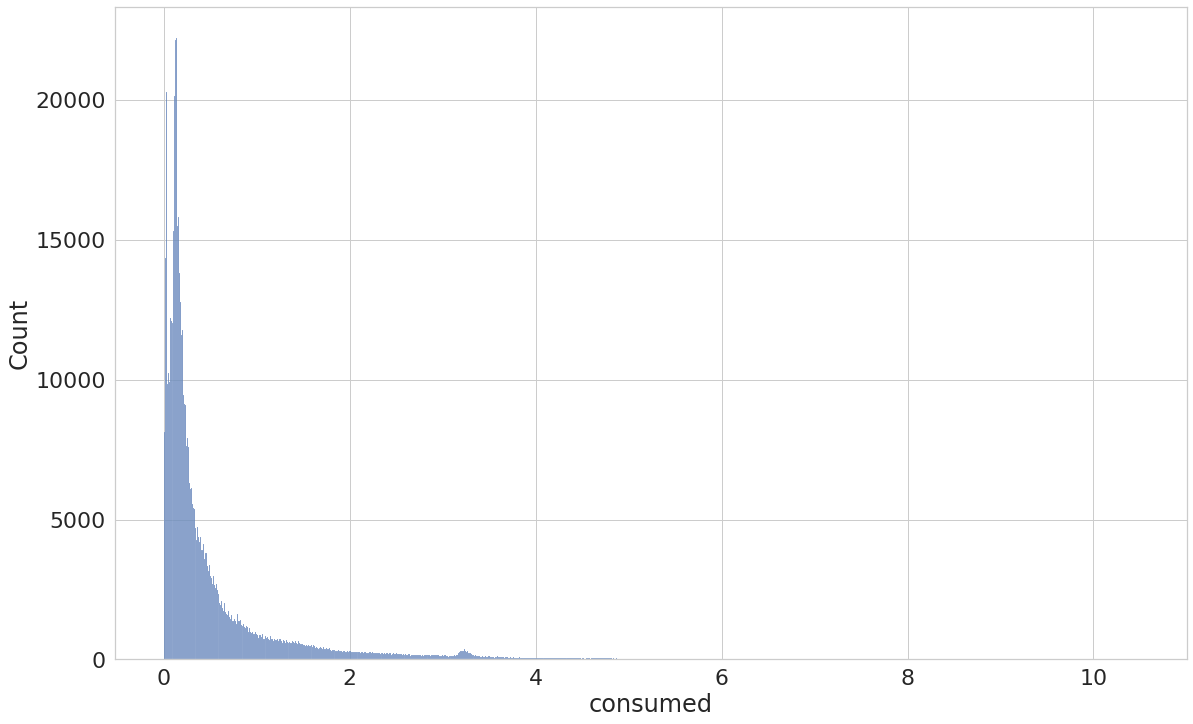

CPU times: user 3.26 s, sys: 64.3 ms, total: 3.32 s
Wall time: 4.68 s


In [13]:
%%time
sns.histplot(data=interval, x='consumed')
plt.show()

Histogram indicates that nearly all values are at or near zero, but at least a small number of usage values exist greater than four kWh. The main dataset has some consumption values greater than 60.

CPU times: user 234 ms, sys: 6.19 ms, total: 240 ms
Wall time: 286 ms


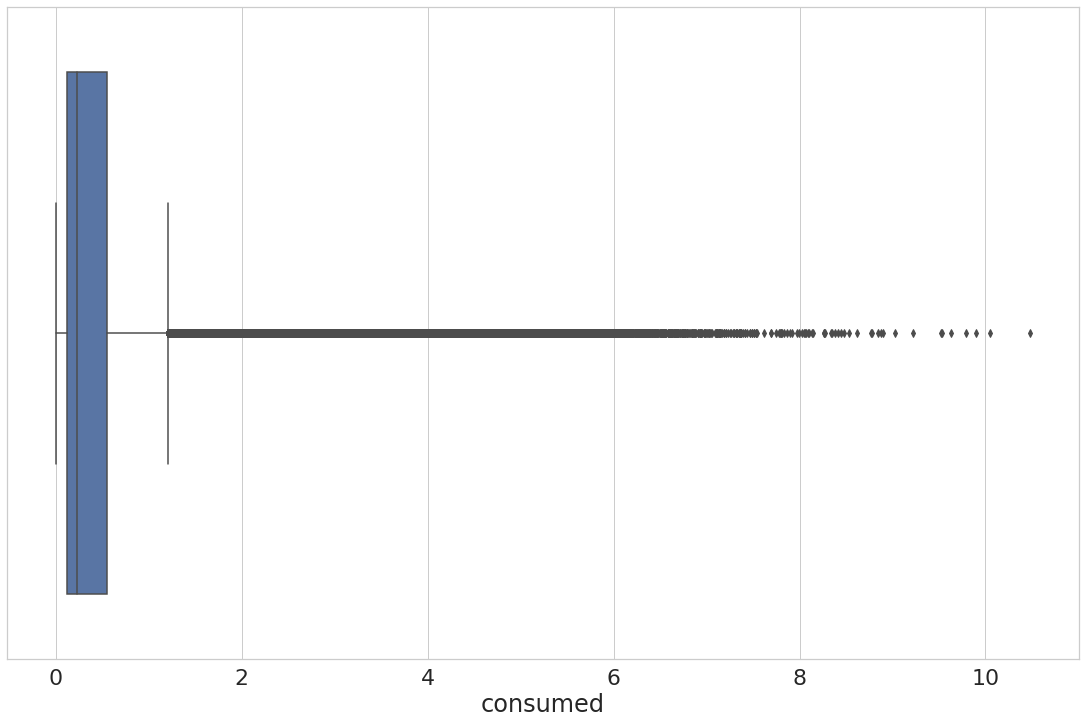

In [14]:
%%time
sns.boxplot(data=interval, x='consumed')

We know that the data set includes both residential and commercial customers. Let's view the distribution with the outliers removed. Outliers here defined as records with `usage` > 1.5 * the interquartile range.

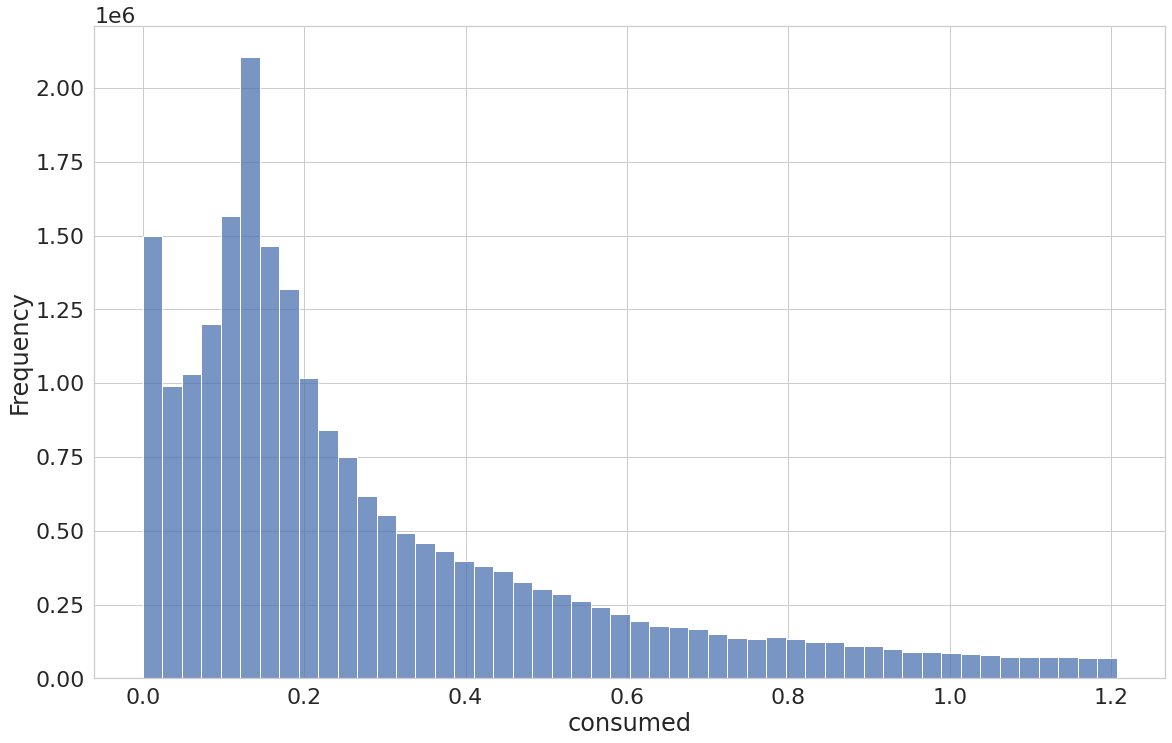

CPU times: user 828 ms, sys: 27 ms, total: 855 ms
Wall time: 1.26 s


In [15]:
%%time

quantiles = interval['consumed'].quantile([0.25, 0.75])
q1 = quantiles.values[0]
q3 = quantiles.values[1]
iqr = q3 - q1

sns.histplot(data=interval[interval.consumed <= (q3 + 1.5*iqr)], x='consumed', bins=50, stat='frequency')
plt.show()

How many observations contain `consumed == 0`?

In [16]:
interval[interval.consumed==0]

,meterId,fdCode,consumed,dayCode,timeCode,timestamp
6064,1524,19535,0.0,195,35,2009-07-15 17:30:00
6075,1524,19546,0.0,195,46,2009-07-15 23:00:00
6083,1524,19606,0.0,196,6,2009-07-16 03:00:00
6088,1524,19611,0.0,196,11,2009-07-16 05:30:00
6093,1524,19616,0.0,196,16,2009-07-16 08:00:00
...,...,...,...,...,...,...
599227,1524,73044,0.0,730,44,2011-01-01 22:00:00
599228,1524,73045,0.0,730,45,2011-01-01 22:30:00
599229,1524,73046,0.0,730,46,2011-01-01 23:00:00
599230,1524,73047,0.0,730,47,2011-01-01 23:30:00


CPU times: user 91.2 ms, sys: 2.89 ms, total: 94.1 ms
Wall time: 151 ms


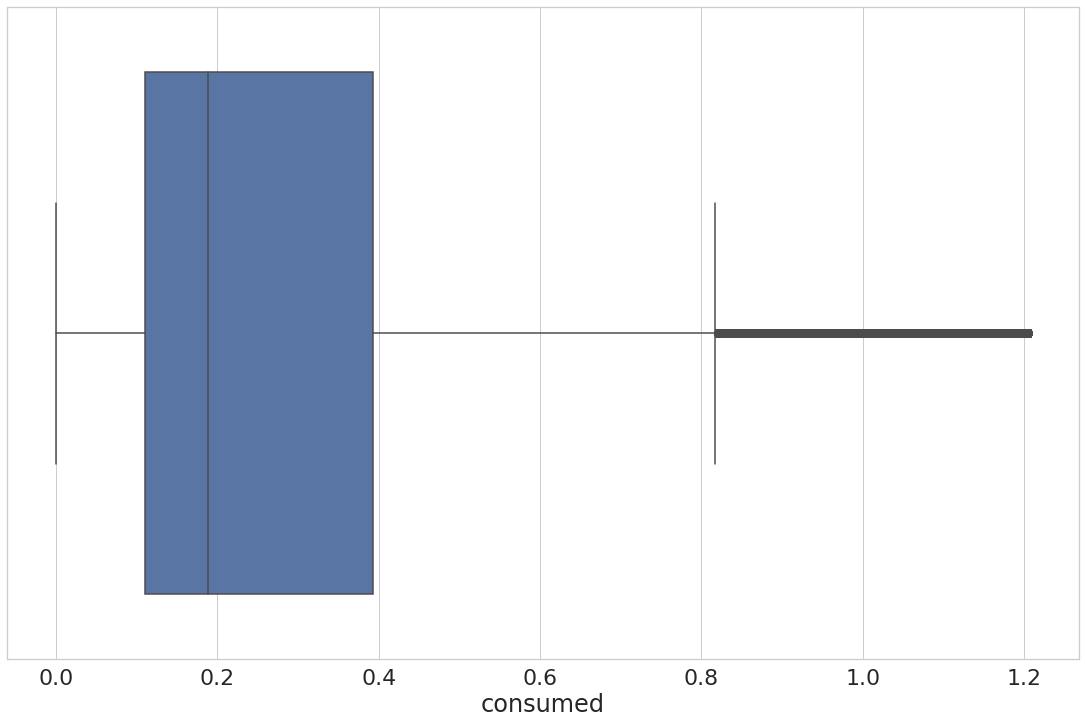

In [17]:
%%time
sns.boxplot(data=interval[interval.consumed <= (q3 + 1.5*iqr)], x='consumed')

The histogram and boxplot shows that the vast majority of observations have a usage value between 0 and 1, with a large number of positive outliers.

#### Missing values

Verify that there are not records with missing or empty values.

Note: were I able to confer with the data owner, I would ask if `consumed` values equal to 0 indicate `0.0 kWh` or nothing recorded.

In [18]:
%%time
interval.isna().sum()

CPU times: user 9.53 ms, sys: 0 ns, total: 9.53 ms
Wall time: 10.6 ms


meterId      0
fdCode       0
consumed     0
dayCode      0
timeCode     0
timestamp    0
dtype: int64

#### Duplicate records
This process uses the `pandas.duplicated()` function to ensure records are not duplicated across the multiple available files. In the case of duplicate records, the first recorded consumption values are retained.

In [19]:
%%time
interval = interval[~interval.duplicated(subset=['meterId','timestamp'])]

CPU times: user 78.1 ms, sys: 3.08 ms, total: 81.2 ms
Wall time: 111 ms


#### Filter out weekends
The analysis focuses on weekdays, which allows for a focus on stable electricity usage patterns from customers. 

In [20]:
%%time
interval = interval[interval.timestamp.dt.dayofweek<5]

CPU times: user 109 ms, sys: 1.97 ms, total: 111 ms
Wall time: 149 ms


#### Calculate the mean for every 30 minute period
Aggregate by customer ID, then calculate the mean usage for every 30-minute interval. The result is a new DataFrame: one row per customer, 48 columns with values equal to the per customer mean usage. This allows us to create a half-hourly load profile.

In [21]:
%%time

# Get the mean consumption across readings (30-min intervals) by meterId
interval_avg = interval.groupby(['meterId',  'timeCode'])['consumed'].mean()

# Unstack: the 2nd index becomes the header
interval_avg = interval_avg.unstack(level=-1)

# prepend "interval_" to each interval in the timeCode column (index)
# interval_avg = interval_avg.add_prefix("interval_")

print(interval_avg.shape)
interval_avg.head()

(25, 48)
CPU times: user 42.1 ms, sys: 2.02 ms, total: 44.1 ms
Wall time: 74.6 ms


timeCode,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
meterId,,,,,,,,,,,,,,,,,,,,,
1042,0.447363,0.344340,0.262262,0.210987,0.150768,0.130010,0.113927,0.111420,0.097337,0.109527,...,1.304405,1.230371,1.017063,0.904217,0.819337,0.761488,0.706992,0.697162,0.696439,0.555932
1048,0.287790,0.234520,0.190430,0.180170,0.158000,0.159820,0.152510,0.140010,0.145390,0.148580,...,1.023140,1.099840,1.101120,1.195620,1.270680,1.114950,1.013300,0.779060,0.515240,0.382810
1078,0.159929,0.125168,0.124323,0.112668,0.113058,0.105825,0.107406,0.104461,0.107806,0.105853,...,0.308330,0.318801,0.361453,0.407262,0.448715,0.444162,0.452751,0.414079,0.305814,0.213115
1083,0.531138,0.450984,0.337589,0.266303,0.222392,0.196405,0.185060,0.170577,0.158945,0.160112,...,0.817360,0.874710,0.898838,1.001642,1.060966,0.988956,0.881778,0.783809,0.702175,0.602356
1194,0.505655,0.442847,0.363414,0.313915,0.282667,0.252068,0.234353,0.217890,0.207246,0.271113,...,1.621339,1.686424,1.623138,1.740698,1.623178,1.496887,1.316203,1.057325,0.814921,0.670528


#### Load additional data

In [22]:
interval_avg = pd.read_csv('https://raw.githubusercontent.com/blcrow/ua101/main/cer_pivot.csv')
print('Shape:', interval_avg.shape)
interval_avg.head()

Shape: (6020, 49)


,meter_id,interval_1,interval_2,interval_3,interval_4,interval_5,interval_6,interval_7,interval_8,interval_9,...,interval_39,interval_40,interval_41,interval_42,interval_43,interval_44,interval_45,interval_46,interval_47,interval_48
0,1000,0.100097,0.067534,0.055955,0.058815,0.053645,0.053076,0.052778,0.052909,0.054107,...,0.503107,0.454961,0.433512,0.432728,0.363193,0.347029,0.333530,0.284107,0.222013,0.166257
1,1001,0.200057,0.202846,0.198139,0.194760,0.197371,0.194232,0.190773,0.193705,0.199922,...,0.195752,0.194196,0.203371,0.198708,0.198410,0.202843,0.201877,0.201170,0.195689,0.188851
2,1002,0.188436,0.130110,0.096804,0.083909,0.075149,0.072559,0.071473,0.072005,0.068862,...,0.274227,0.294762,0.319778,0.336935,0.364621,0.363253,0.367240,0.363762,0.348097,0.281751
3,1003,0.567961,0.536076,0.499257,0.447995,0.428689,0.404285,0.382198,0.365094,0.384029,...,1.056833,0.960867,0.888554,0.864486,0.856710,0.829423,0.818402,0.742366,0.678543,0.615783
4,1004,1.001149,0.878026,0.765110,0.673648,0.611713,0.556530,0.501992,0.449695,0.417781,...,2.195723,2.160961,1.937637,1.919269,1.848953,1.849410,1.706154,1.550078,1.278820,1.135233


#### Plot the consumption curve for individual customers

In [23]:
interval_avg.set_index('meter_id', inplace=True)

In [24]:
interval_avg_melt = pd.melt(interval_avg.reset_index(), id_vars=['meter_id'], value_name='avg_usage') # wide to long
interval_avg_melt['interval'] = pd.melt(interval_avg.reset_index(), id_vars=['meter_id'], value_name='avg_usage').variable.str.rpartition('_')[2] # get the interval number (split)
interval_avg_melt.head()

,meter_id,variable,avg_usage,interval
0,1000,interval_1,0.100097,1
1,1001,interval_1,0.200057,1
2,1002,interval_1,0.188436,1
3,1003,interval_1,0.567961,1
4,1004,interval_1,1.001149,1


In [25]:
def plot_avg_usage(data, meter):
    title = 'Percentage Load Curve for Meter ' + str(meter)
    # tmp = pd.melt(data.reset_index(), id_vars=['meter_id'], value_name='avg_usage')
    ax = sns.lineplot(data=data[data.meter_id==meter], x='interval', y='avg_usage')
    ax.set(xlabel='Interval', ylabel='Usage', title=title)
    plt.xticks([-1, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49])
    plt.show()

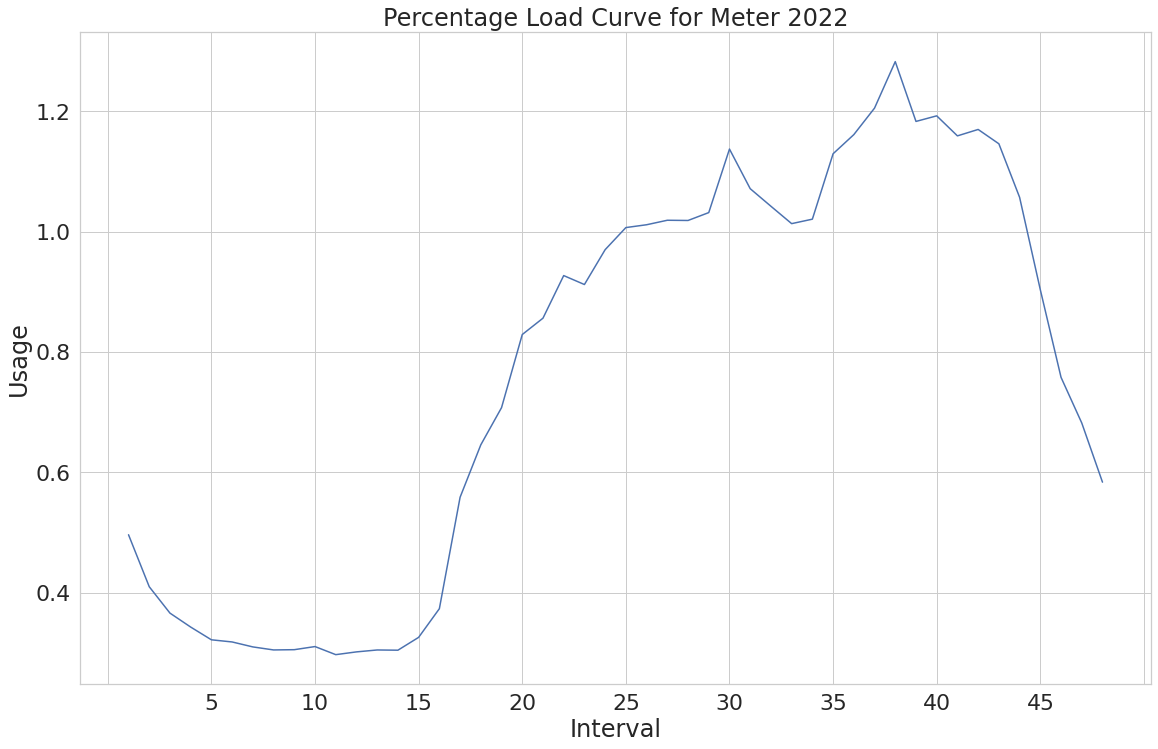

In [26]:
plot_avg_usage(interval_avg_melt, 2022)

#### Load customer segment data

In [27]:
segment = pd.read_csv('https://raw.githubusercontent.com/blcrow/ua101/main/customer_cluster.csv')
segment.head()

,meterId,cluster
0,1000,0
1,1001,1
2,1002,1
3,1003,1
4,1004,1


In [28]:
segment.set_index('meterId', inplace=True)

In [29]:
segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6433 entries, 1000 to 7444
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   cluster  6433 non-null   int64
dtypes: int64(1)
memory usage: 100.5 KB


#### Join the profile and segment datasets

In [30]:
cust_avg_usage_with_cluster = interval_avg.merge(segment, left_index=True, right_index=True)

In [31]:
cust_avg_usage_with_cluster.head()

,interval_1,interval_2,interval_3,interval_4,interval_5,interval_6,interval_7,interval_8,interval_9,interval_10,...,interval_40,interval_41,interval_42,interval_43,interval_44,interval_45,interval_46,interval_47,interval_48,cluster
1000,0.100097,0.067534,0.055955,0.058815,0.053645,0.053076,0.052778,0.052909,0.054107,0.050240,...,0.454961,0.433512,0.432728,0.363193,0.347029,0.333530,0.284107,0.222013,0.166257,0
1001,0.200057,0.202846,0.198139,0.194760,0.197371,0.194232,0.190773,0.193705,0.199922,0.191619,...,0.194196,0.203371,0.198708,0.198410,0.202843,0.201877,0.201170,0.195689,0.188851,1
1002,0.188436,0.130110,0.096804,0.083909,0.075149,0.072559,0.071473,0.072005,0.068862,0.072449,...,0.294762,0.319778,0.336935,0.364621,0.363253,0.367240,0.363762,0.348097,0.281751,1
1003,0.567961,0.536076,0.499257,0.447995,0.428689,0.404285,0.382198,0.365094,0.384029,0.484266,...,0.960867,0.888554,0.864486,0.856710,0.829423,0.818402,0.742366,0.678543,0.615783,1
1004,1.001149,0.878026,0.765110,0.673648,0.611713,0.556530,0.501992,0.449695,0.417781,0.385804,...,2.160961,1.937637,1.919269,1.848953,1.849410,1.706154,1.550078,1.278820,1.135233,1


#### Plot consumption curve for each cluster

Reset the index and rename `'index'` to `'meterId'`.

In [32]:
cust_avg_usage_with_cluster.reset_index(inplace=True)
cust_avg_usage_with_cluster.rename(columns={'index':'meterId'}, inplace=True)
cust_avg_usage_with_cluster.head()

,meterId,interval_1,interval_2,interval_3,interval_4,interval_5,interval_6,interval_7,interval_8,interval_9,...,interval_40,interval_41,interval_42,interval_43,interval_44,interval_45,interval_46,interval_47,interval_48,cluster
0,1000,0.100097,0.067534,0.055955,0.058815,0.053645,0.053076,0.052778,0.052909,0.054107,...,0.454961,0.433512,0.432728,0.363193,0.347029,0.333530,0.284107,0.222013,0.166257,0
1,1001,0.200057,0.202846,0.198139,0.194760,0.197371,0.194232,0.190773,0.193705,0.199922,...,0.194196,0.203371,0.198708,0.198410,0.202843,0.201877,0.201170,0.195689,0.188851,1
2,1002,0.188436,0.130110,0.096804,0.083909,0.075149,0.072559,0.071473,0.072005,0.068862,...,0.294762,0.319778,0.336935,0.364621,0.363253,0.367240,0.363762,0.348097,0.281751,1
3,1003,0.567961,0.536076,0.499257,0.447995,0.428689,0.404285,0.382198,0.365094,0.384029,...,0.960867,0.888554,0.864486,0.856710,0.829423,0.818402,0.742366,0.678543,0.615783,1
4,1004,1.001149,0.878026,0.765110,0.673648,0.611713,0.556530,0.501992,0.449695,0.417781,...,2.160961,1.937637,1.919269,1.848953,1.849410,1.706154,1.550078,1.278820,1.135233,1


Convert wide data to long form.

In [33]:
melt = pd.melt(cust_avg_usage_with_cluster, id_vars=['meterId', 'cluster'], value_name='avg_usage') # wide to long
melt.head()

,meterId,cluster,variable,avg_usage
0,1000,0,interval_1,0.100097
1,1001,1,interval_1,0.200057
2,1002,1,interval_1,0.188436
3,1003,1,interval_1,0.567961
4,1004,1,interval_1,1.001149


Split `'variable'` to get the integer interval.

In [34]:
melt['interval'] = melt.variable.str.rpartition('_')[2] # get the interval number (split)

Plot the clusters with `seaborn.relplot()`.

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


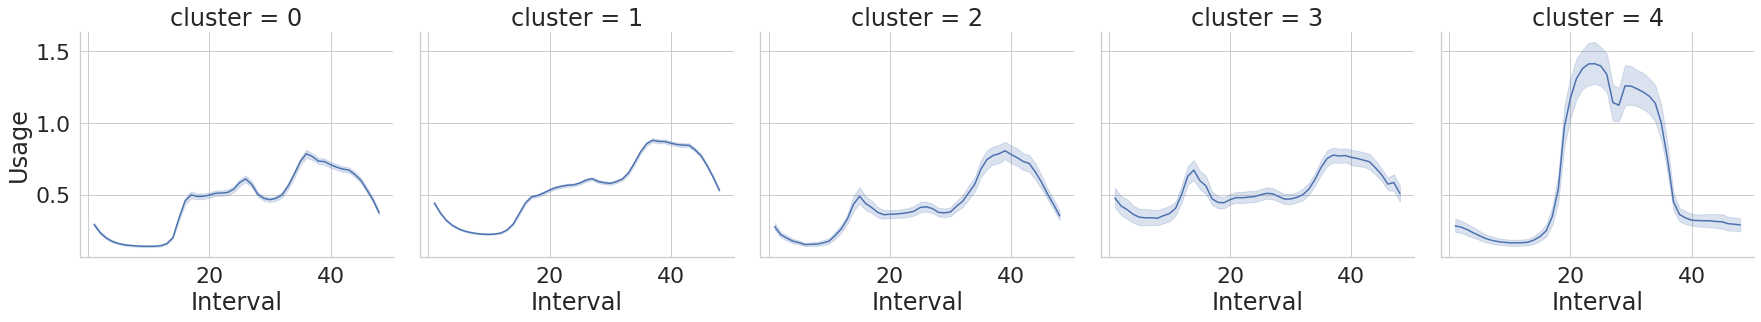

In [35]:
%time 
ax = sns.relplot(data=melt, x='interval', y='avg_usage', col='cluster', kind='line')
ax.set(xlabel='Interval', ylabel='Usage')
plt.xticks([-1, 19, 39])
plt.show()

Plot the clusters together in a single plot.

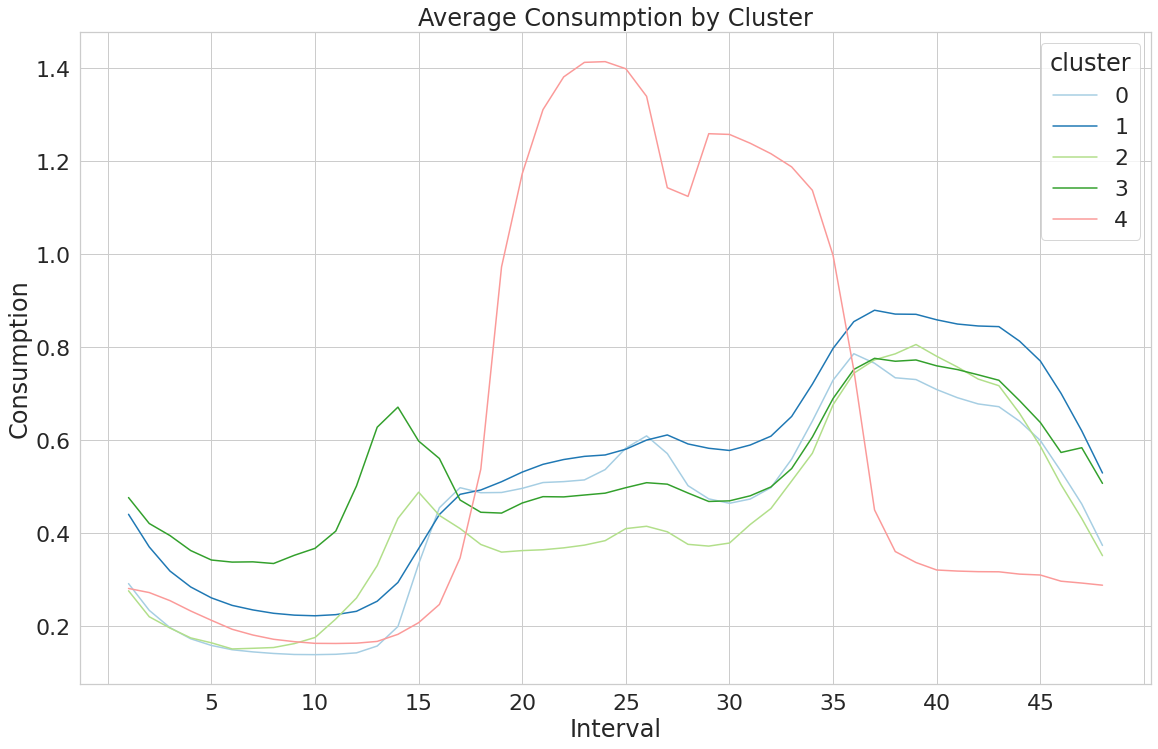

In [36]:
ax = sns.lineplot(data=melt, x='interval', y='avg_usage', hue='cluster', palette="Paired", legend=True, ci=None)
ax.set(xlabel='Interval', ylabel='Consumption', title="Average Consumption by Cluster")
plt.xticks([-1, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49])

# ax.text(38.5, 0.01, "Cluster 4", size=17)
# ax.text(38.5, 0.026, "Cluster 3", size=17)
# ax.text(38.5, 0.0305, "Cluster 1", size=17)
# ax.text(38.5, 0.0346, "Cluster 0", size=17)
# ax.text(38.5, 0.0395, "Cluster 2", size=17)

plt.show()

#### Peak Time

**Peak time** hours fluxuate based on region, season, weather, and other factors. (For example, OGE currently defines peak hours as Monday-Friday, 2:00 - 7:00PM from June 1st to September 30th.) For the purpose of demonstrating this concept, we might define peak time arbitrarily as when the average electricity usage is at least 25% higher than it should be in the case of an evenly distributed usage (regardless of season, weather, etc). 

In [48]:
interval_avg_melt['interval'] = interval_avg_melt['interval'].astype('int')
sum_by_int = interval_avg_melt.groupby('interval')['avg_usage'].sum()
sum_by_int.head()

interval
1    2390.306957
2    2005.113067
3    1735.189247
4    1549.540069
5    1425.643530
Name: avg_usage, dtype: float64

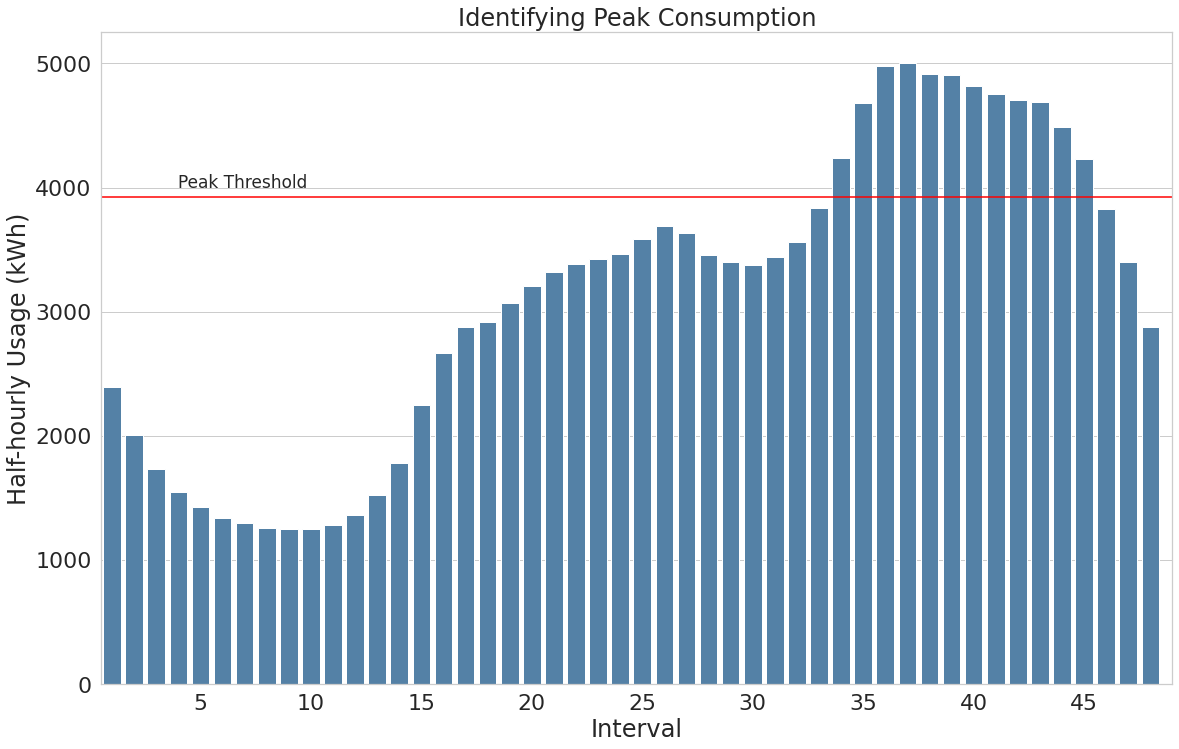

In [60]:
ax = sns.barplot(x=sum_by_int.index, y=sum_by_int.values, color='steelblue')

ax.set(xlabel='Interval', ylabel='Half-hourly Usage (kWh)', title="Identifying Peak Consumption")
ax.axhline(sum_by_int.sum() / 48 * 1.25, color="red")

ax.text(3, 4000, "Peak Threshold", size=17)

ax.set_xticks([0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 48])
ax.set_xticklabels(['', '5', '10', '15', '20', '25', '30', '35', '40', '45'])

plt.show()

Calculate the proportion of usage per interval. Good candidates are those who use more electricity "off-peak" than they should in the case of an evenly distributed usage. Peak time accounts for 25% of the day (12/48 intervals). Those who use less than 25% of their electricity during peak hours are good candidates for DR. 

In this case only cluster 4 qualifies as optimal candidates for DR. Cluster 3 might also be considered due to the relatively low peak usage.

In [84]:
peak = ['interval_34', 'interval_35', 'interval_36', 'interval_37', 'interval_38', 
        'interval_39', 'interval_40', 'interval_41', 'interval_42', 'interval_43', 
        'interval_44', 'interval_45']

tbl = (pd.DataFrame(cust_avg_usage_with_cluster.groupby('cluster')[peak].sum().sum(axis=1) / 
                    cust_avg_usage_with_cluster.iloc[:, 1:].groupby('cluster').sum().sum(axis=1), columns=['Peak Usage %']) * 100).round(2)

tbl

,Peak Usage %
cluster,
0,38.55
1,38.18
2,41.65
3,33.82
4,19.91


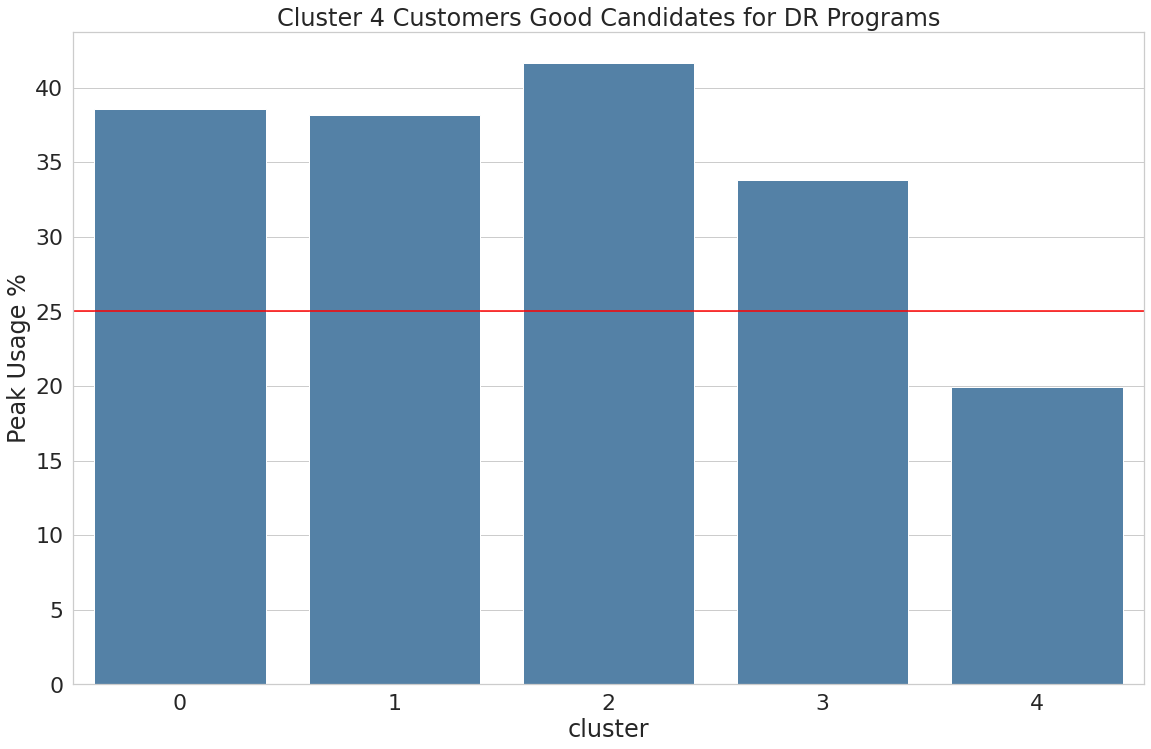

In [85]:
ax = sns.barplot(x=tbl.index, y=tbl['Peak Usage %'], color='steelblue')
ax.set(title='Cluster 4 Customers Good Candidates for DR Programs')
ax.axhline(25, color="red")
plt.show()

This project was inspired by Martinez-Pabon, M., Eveleigh, T and Tanju, B. (2016). Smart meter data analytics for optimal customer selection in demand response programs. _Energy Procedia_(107) 49 – 59. 

References

1. Martinez-Pabon, M., Eveleigh, T and Tanju, B. (2016). Smart meter data analytics for optimal customer selection in demand response programs. _Energy Procedia_(107) 49 – 59. 
2. https://www.cpuc.ca.gov/industries-and-topics/electrical-energy/electric-costs/demand-response-dr
3. Commission for Energy Regulation (CER). (2012). CER Smart Metering Project - Electricity Customer Behaviour Trial, 2009-2010 [dataset]. 1st Edition. Irish Social Science Data Archive. SN: 0012-00. https://www.ucd.ie/issda/data/commissionforenergyregulationcer/.
4. VanderPlas, J. (2016). _Python Data Science Handbook_. O'Reilly Media, Inc. https://jakevdp.github.io/PythonDataScienceHandbook/. 